# Spectrum changes with single lens imaging

At first, the pupil flane in frequency domain should be reveal.

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io as sio
from skimage.transform import resize
import os
import numpy as np
import sys
import imp
sys.path.append("D:\\Workspace\\git_proj\\CCCode")
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

PIXEL_SIZE = 5e-6
PIXEL_NUM = 512
WAVELENGTH = 500e-9

In [68]:
# import images
imgs_path = "D:\\Workspace\\datasets\\open_image_val_standard"
imgs_name_list = os.listdir(imgs_path)[0:2]
imgs_fpath_list = [os.path.join(imgs_path, img_name) for img_name in imgs_name_list]
amp_img = img_val_norm(resize(sio.imread(imgs_fpath_list[0]), (PIXEL_NUM, PIXEL_NUM)), 0.8, 1)
pha_img = img_val_norm(resize(sio.imread(imgs_fpath_list[1]), (PIXEL_NUM, PIXEL_NUM)), 0.2, 1.5)

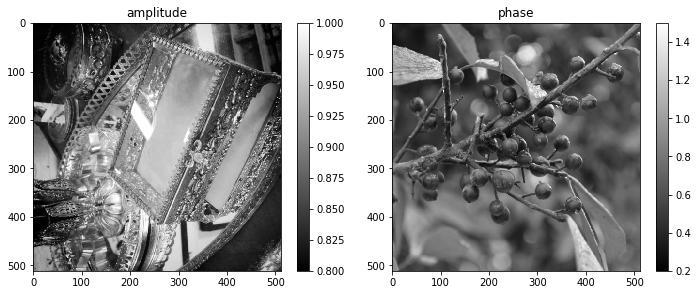

In [69]:
plt.figure(figsize=[10, 4])
plt.subplot(121)
plt.imshow(amp_img, cmap="gray")
plt.title("amplitude")
plt.colorbar()
plt.subplot(122)
plt.imshow(pha_img, cmap="gray")
plt.title("phase")
plt.colorbar()
plt.tight_layout()
plt.show()

In [72]:
import imaging_process
imp.reload(imaging_process)
from imaging_process import ft2, ift2, Wavefront, tie_solution, img_val_norm, Check

delta_d = 1e-3
ff = 0.1
d1 = 2*ff
d2f = 2*ff
d21 = d2f - delta_d
d22 = d2f + delta_d

wf_obj = Wavefront.from_bioimage(amp_img, pha_img, WAVELENGTH, PIXEL_SIZE)
imaging_pl_minus = wf_obj.lens_transfer(d1=d1, focus=ff, d2=d21)
imaging_pl_focus = wf_obj.lens_transfer(d1=d1, focus=ff, d2=d2f)
imaging_pl_plus = wf_obj.lens_transfer(d1=d1, focus=ff, d2=d22)

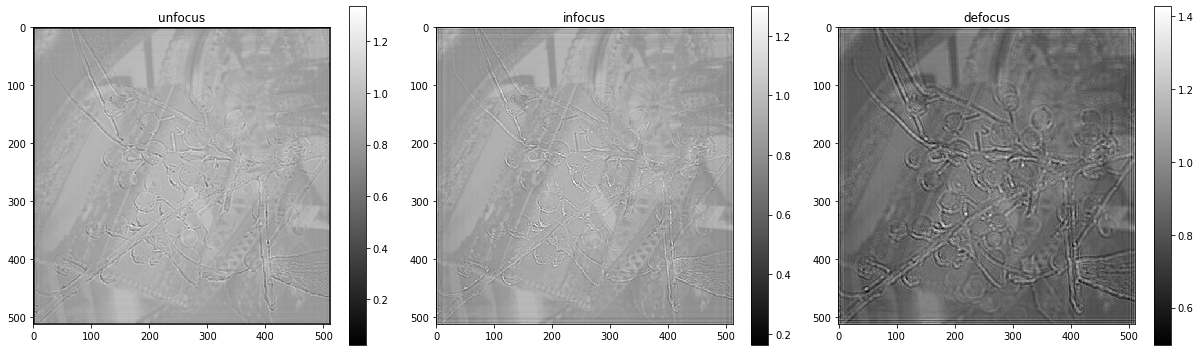

In [73]:
plt.figure(figsize=[17, 5])
plt.subplot(131)
plt.imshow(abs(imaging_pl_minus), cmap="gray")
plt.title("unfocus")
plt.colorbar()
plt.subplot(132)
plt.imshow(abs(imaging_pl_focus), cmap="gray")
plt.title("infocus")
plt.colorbar()
plt.subplot(133)
plt.imshow(abs(imaging_pl_plus), cmap="gray")
plt.title("defocus")
plt.colorbar()
plt.tight_layout()
plt.show()

amp min: 0.11464907494103946 amp max: 141837.35724627797
pha min: -3.141580928231549 pha max: 3.1415771065100055


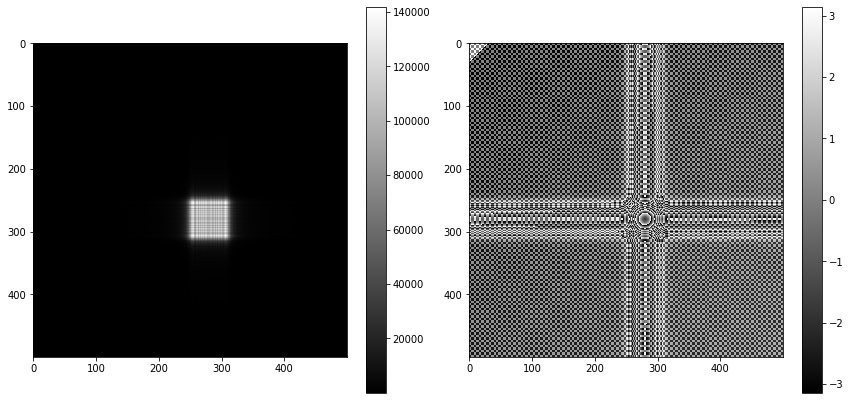

In [23]:
wf_obj = Wavefront.from_bioimage(amp_img, pha_img, WAVELENGTH, PIXEL_SIZE)
t = wf_obj.lens_transfer(0.2)
ck = Check()
ck.wavefront(ft2(t)[1000:1500, 1000:1500])